# Alphalens: intraday factor

In this notebook we use Alphalens to analyse the performance of an intraday factor, which is computed daily but the stocks are bought at marker open and sold at market close with no overnight positions.

In [1]:
%pylab inline --no-import-all
import alphalens
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


/home/lucasca/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

Below is a simple mapping of tickers to sectors for a small universe of large cap stocks.

In [3]:
sector_names = {
    0 : "information_technology",
    1 : "financials",
    2 : "health_care",
    3 : "industrials",
    4 : "utilities", 
    5 : "real_estate", 
    6 : "materials", 
    7 : "telecommunication_services", 
    8 : "consumer_staples", 
    9 : "consumer_discretionary", 
    10 : "energy" 
}

ticker_sector = {
    "ACN" : 0, "ATVI" : 0, "ADBE" : 0, "AMD" : 0, "AKAM" : 0, "ADS" : 0, "GOOGL" : 0, "GOOG" : 0, 
    "APH" : 0, "ADI" : 0, "ANSS" : 0, "AAPL" : 0, "AMAT" : 0, "ADSK" : 0, "ADP" : 0, "AVGO" : 0,
    "AMG" : 1, "AFL" : 1, "ALL" : 1, "AXP" : 1, "AIG" : 1, "AMP" : 1, "AON" : 1, "AJG" : 1, "AIZ" : 1, "BAC" : 1,
    "BK" : 1, "BBT" : 1, "BRK.B" : 1, "BLK" : 1, "HRB" : 1, "BHF" : 1, "COF" : 1, "CBOE" : 1, "SCHW" : 1, "CB" : 1,
    "ABT" : 2, "ABBV" : 2, "AET" : 2, "A" : 2, "ALXN" : 2, "ALGN" : 2, "AGN" : 2, "ABC" : 2, "AMGN" : 2, "ANTM" : 2,
    "BCR" : 2, "BAX" : 2, "BDX" : 2, "BIIB" : 2, "BSX" : 2, "BMY" : 2, "CAH" : 2, "CELG" : 2, "CNC" : 2, "CERN" : 2,
    "MMM" : 3, "AYI" : 3, "ALK" : 3, "ALLE" : 3, "AAL" : 3, "AME" : 3, "AOS" : 3, "ARNC" : 3, "BA" : 3, "CHRW" : 3,
    "CAT" : 3, "CTAS" : 3, "CSX" : 3, "CMI" : 3, "DE" : 3, "DAL" : 3, "DOV" : 3, "ETN" : 3, "EMR" : 3, "EFX" : 3,
    "AES" : 4, "LNT" : 4, "AEE" : 4, "AEP" : 4, "AWK" : 4, "CNP" : 4, "CMS" : 4, "ED" : 4, "D" : 4, "DTE" : 4,
    "DUK" : 4, "EIX" : 4, "ETR" : 4, "ES" : 4, "EXC" : 4, "FE" : 4, "NEE" : 4, "NI" : 4, "NRG" : 4, "PCG" : 4,
    "ARE" : 5, "AMT" : 5, "AIV" : 5, "AVB" : 5, "BXP" : 5, "CBG" : 5, "CCI" : 5, "DLR" : 5, "DRE" : 5,
    "EQIX" : 5, "EQR" : 5, "ESS" : 5, "EXR" : 5, "FRT" : 5, "GGP" : 5, "HCP" : 5, "HST" : 5, "IRM" : 5, "KIM" : 5,
    "APD" : 6, "ALB" : 6, "AVY" : 6, "BLL" : 6, "CF" : 6, "DWDP" : 6, "EMN" : 6, "ECL" : 6, "FMC" : 6, "FCX" : 6,
    "IP" : 6, "IFF" : 6, "LYB" : 6, "MLM" : 6, "MON" : 6, "MOS" : 6, "NEM" : 6, "NUE" : 6, "PKG" : 6, "PPG" : 6,
    "T" : 7, "CTL" : 7, "VZ" : 7, 
    "MO" : 8, "ADM" : 8, "BF.B" : 8, "CPB" : 8, "CHD" : 8, "CLX" : 8, "KO" : 8, "CL" : 8, "CAG" : 8,
    "STZ" : 8, "COST" : 8, "COTY" : 8, "CVS" : 8, "DPS" : 8, "EL" : 8, "GIS" : 8, "HSY" : 8, "HRL" : 8,
    "AAP" : 9, "AMZN" : 9, "APTV" : 9, "AZO" : 9, "BBY" : 9, "BWA" : 9, "KMX" : 9, "CCL" : 9, 
    "APC" : 10, "ANDV" : 10, "APA" : 10, "BHGE" : 10, "COG" : 10, "CHK" : 10, "CVX" : 10, "XEC" : 10, "CXO" : 10,
    "COP" : 10, "DVN" : 10, "EOG" : 10, "EQT" : 10, "XOM" : 10, "HAL" : 10, "HP" : 10, "HES" : 10, "KMI" : 10
}

In [4]:
import pandas_datareader.data as web

tickers = list(ticker_sector.keys())
pan = web.DataReader(tickers, "google", datetime.datetime(2017, 1, 1),  datetime.datetime(2017, 6, 1))

Our example factor ranks the stocks based on their overnight price gap (yesterday close to today open price). We'll  see if the factor has some alpha or if it is pure noise.

In [5]:
today_open = pan['Open']
today_close = pan['Close']
yesterday_close = today_close.shift(1)

In [6]:
factor = (today_open - yesterday_close) / yesterday_close

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestamps will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, we want to buy the stocks at marker open, so the need the open price at the exact timestamps as the factor valules, and we want to sell the stocks at market close so we will add the close prices too, which will be used to compute period 1 forward returns as they appear just after the factor values timestamps. The returns computed by Alphalens will therefore be based on the difference between open to close assets prices.

If we had other prices we could compute other period returns, for example one hour after market open and 2 hours and so on. We could have added those prices right after the open prices and instruct Alphalens to compute 1, 2, 3... periods too  and not only period 1 like in this example.

In [7]:
# Fix time as Yahoo doesn't set it
today_open.index += pd.Timedelta('9h30m')
today_close.index += pd.Timedelta('16h')
# pricing will contain both open and close
pricing = pd.concat([today_open, today_close]).sort_index()

In [8]:
pricing.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,NUE,PCG,PKG,PPG,SCHW,STZ,T,VZ,XEC,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:00,45.93,47.28,170.78,115.8,62.92,78.51,NaN,117.38,103.43,72.6,...,59.74,60.81,85.16,95.43,40.05,155.01,NaN,53.96,137.53,90.94
2017-01-03 16:00:00,46.49,46.3,170.6,116.15,62.41,82.61,39.3,116.46,103.48,72.5,...,59.61,60.37,85,95.25,40.2,154.75,43.58,54.58,138.79,90.89
2017-01-04 09:30:00,46.93,46.63,170.37,115.85,62.64,82.6,40.2,116.91,103.74,72.77,...,59.76,60.61,85.44,95.71,40.4,157.15,NaN,54.55,138.48,91.12
2017-01-04 16:00:00,47.1,46.7,172,116.02,63.29,84.66,40.2,116.74,104.14,72.36,...,61.25,60.59,86.37,97.27,41.22,157.99,43.58,54.52,138.5,89.89
2017-01-05 09:30:00,47.05,46.52,170.87,115.92,63.38,84.38,NaN,116.98,104.13,72.41,...,61.12,60.66,86.37,96.46,40.97,150.55,NaN,54.78,138.5,90.19


In [9]:
# Align factor to open price
factor.index += pd.Timedelta('9h30m')
factor = factor.stack()
factor.index = factor.index.set_names(['date', 'asset'])

In [10]:
factor.unstack().head()

asset,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,NUE,PCG,PKG,PPG,SCHW,STZ,T,VZ,XEC,XOM
date,,,,,,,,,,,,,,,,,,,,,
2017-01-04 09:30:00,0.0094644,0.00712743,-0.00134818,-0.00258287,0.00368531,-0.000121051,0.0229008,0.00386399,0.00251256,0.00372414,...,0.00251636,0.00397548,0.00517647,0.0048294,0.00497512,0.0155089,None,-0.000549652,-0.00223359,0.00253053
2017-01-05 09:30:00,-0.00106157,-0.00385439,-0.00656977,-0.00086192,0.00142203,-0.00330735,None,0.00205585,-9.60246e-05,0.000690989,...,-0.00212245,0.00115531,0,-0.00832734,-0.00606502,-0.0470916,None,0.00476889,0,0.00333741
2017-01-06 09:30:00,0.00193382,-0.00087165,-0.00325809,0.00145785,0.00172495,-0.00179254,None,0,0.000660939,0.00364554,...,-0.000328407,-0.0033036,0.000468768,0.00156871,0.00805467,0.00163543,None,-0.0177526,0.00178431,0.00271033
2017-01-09 09:30:00,0.000416753,-0.00432807,0.00253493,0.000339242,0.000156764,-0.00235849,None,-0.00137575,-0.00313943,0.000558659,...,0.00978603,-0.000326691,-0.00344037,-0.00564913,-0.00557846,0.00374732,None,-0.000751033,-0.0112849,-0.00316384
2017-01-10 09:30:00,0.00415455,-0.00169924,-0.00489589,-0.00184889,-0.00249182,-0.00444548,None,-0.000521739,0,-0.000973033,...,0.0127431,0.000497512,-0.000797539,-0.00290607,0.00170233,-0.00179677,-0.0631023,0.000189825,0.00466418,0.00149357


# Run Alphalens

Period 1 will show returns from market open to market close while period 2 will show returns from today open to tomorrow open

In [11]:
non_predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, 
                                                                                  pricing, 
                                                                                  periods=(1,2),
                                                                                  groupby=ticker_sector,
                                                                                  groupby_labels=sector_names)

Dropped 4.6% entries from factor data: 4.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Returns Analysis


,6h30m,1D
Ann. alpha,0.086,-0.065
beta,0.115,0.140
Mean Period Wise Return Top Quantile (bps),-7.813,-1.918
Mean Period Wise Return Bottom Quantile (bps),0.385,0.555
Mean Period Wise Spread (bps),-8.024,-2.408


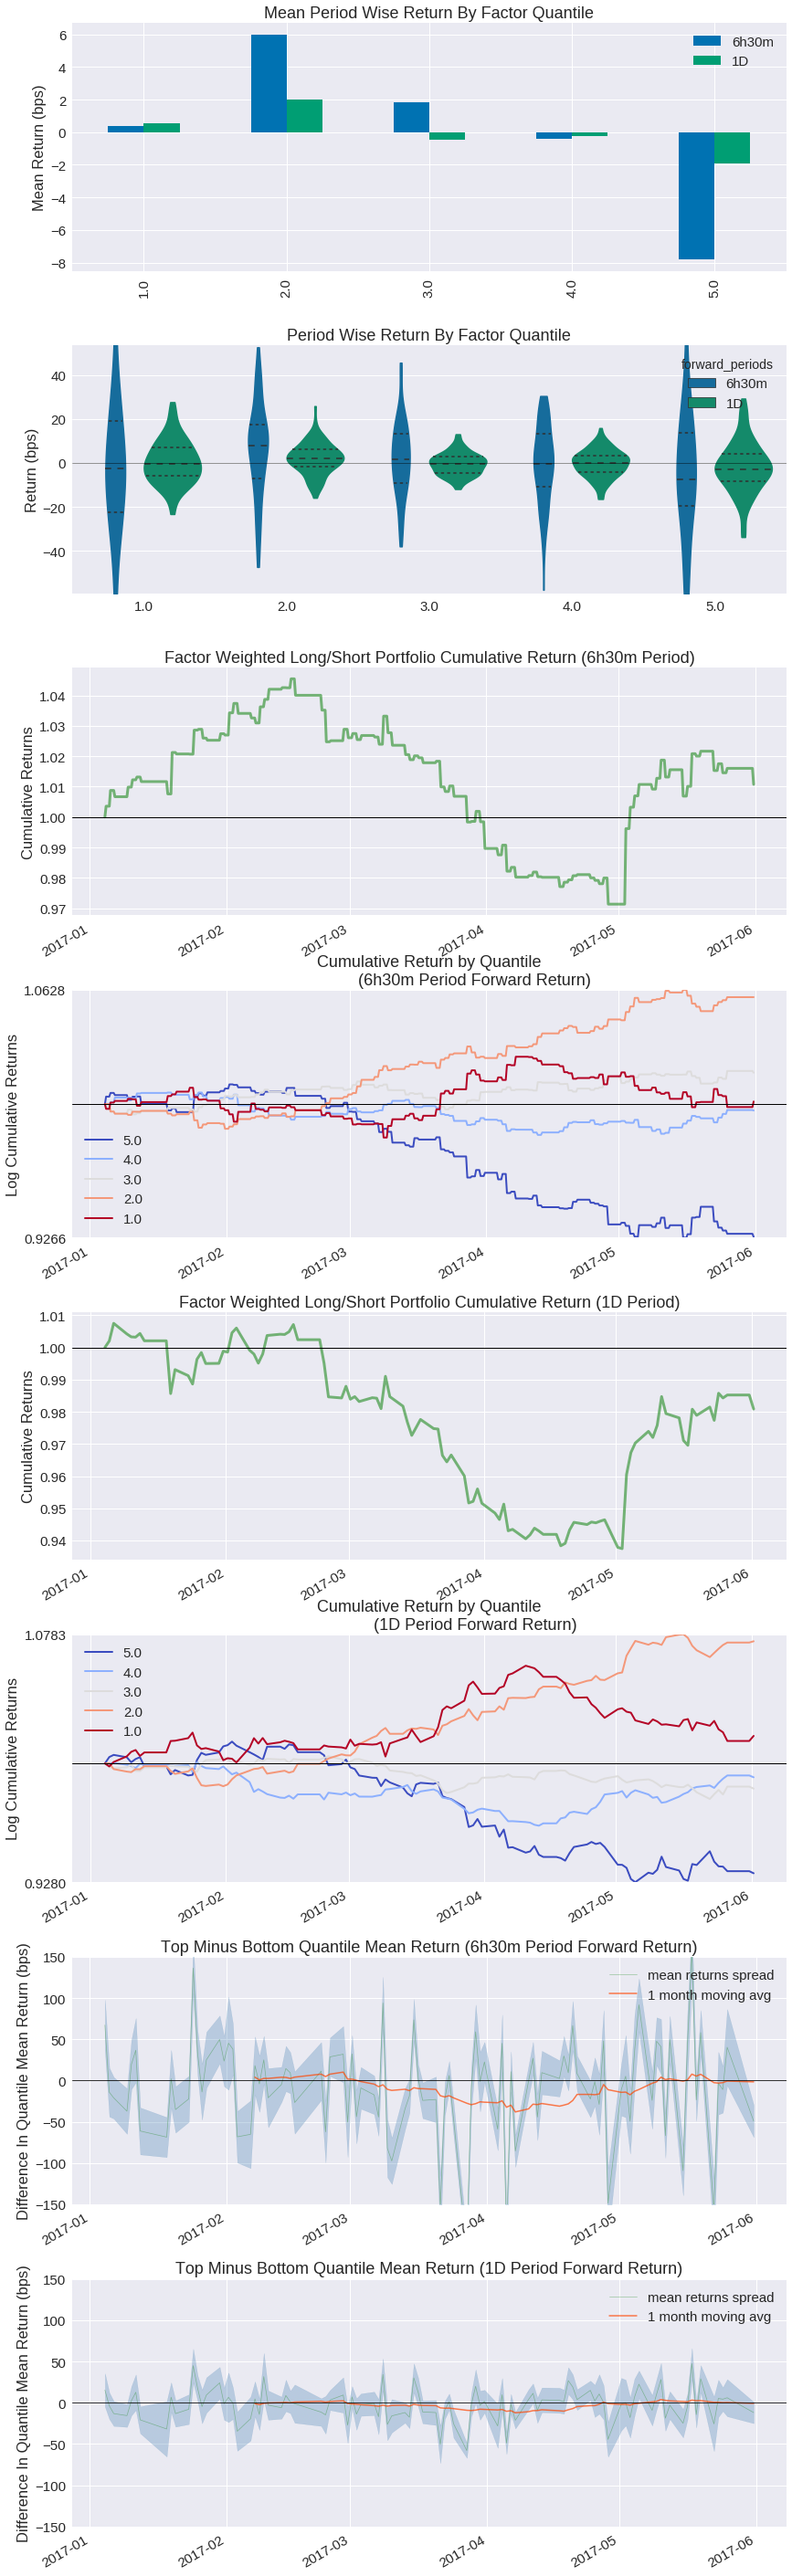

In [12]:
alphalens.tears.create_returns_tear_sheet(non_predictive_factor_data)

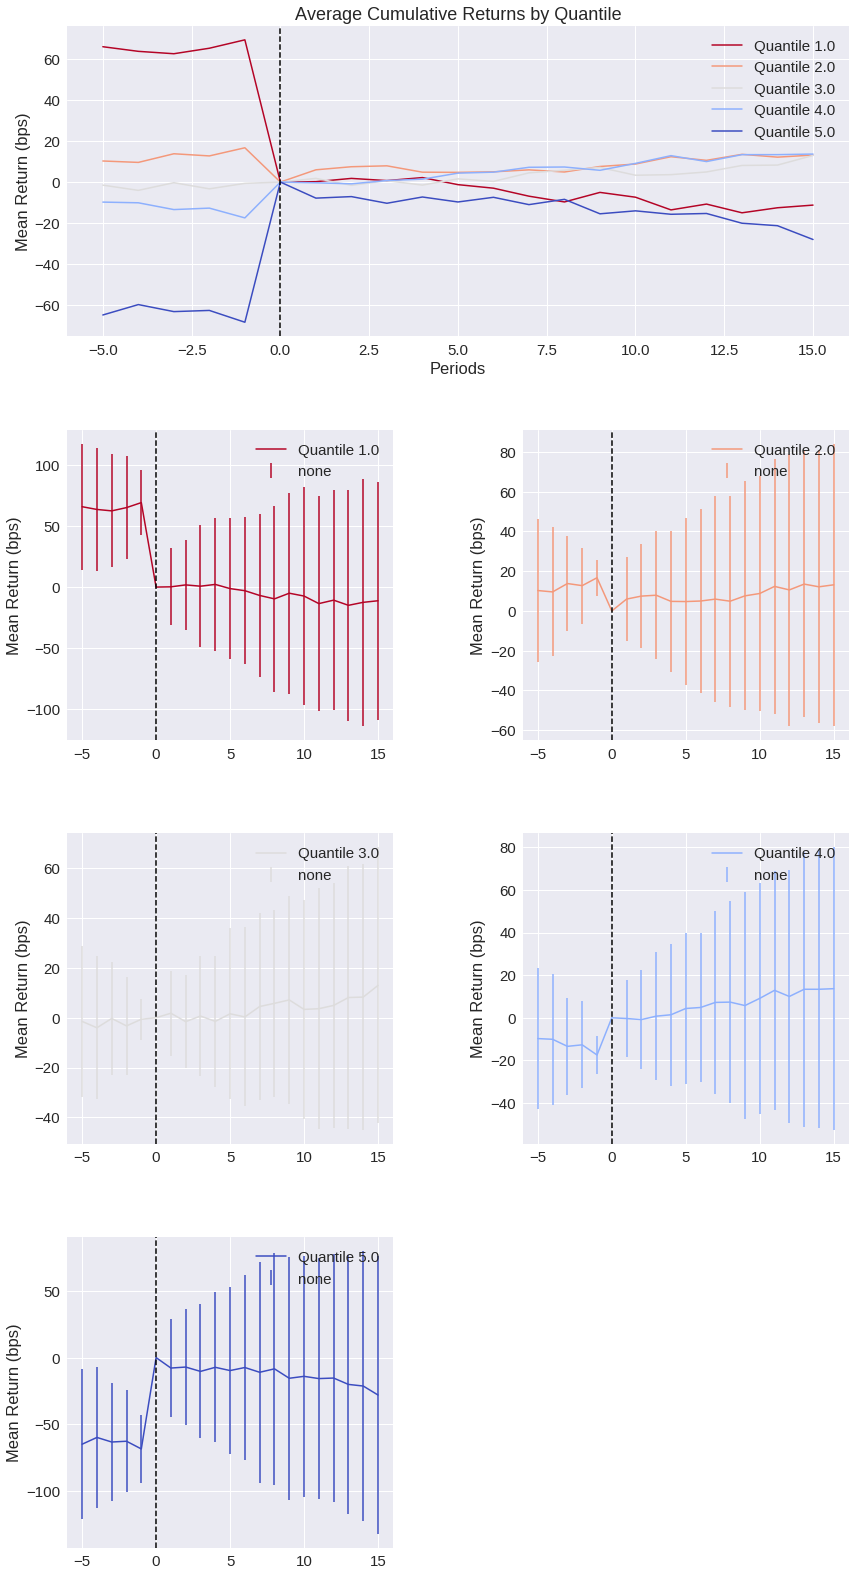

In [13]:
alphalens.tears.create_event_returns_tear_sheet(non_predictive_factor_data, pricing)